In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import yfinance as yf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

The analysis and model training were conducted using a variety of libraries and tools:
- Matplotlib is a library utilised for generating visual representations, such as displaying the trends of stock prices and the performance of the RNN model. Matplotlib is a crucial tool for visualising data in Python, offering a diverse array of charting tools and customisation features.
- Pandas is a robust Python library for manipulating data. It was utilised for managing and preparing the stock data obtained from Yahoo Finance. The main purpose of this tool is to streamline the process of analysing and manipulating data, particularly when dealing with structured data such as time series.
- NumPy, a crucial library for scientific computing in Python, was utilised for doing numerical computations. Within this specific framework, it proved to be quite advantageous for managing arrays and performing essential mathematical operations required for data preprocessing and constructing models.
- yfinance: This library offers a simple method to retrieve financial market data from Yahoo Finance. The purpose of its usage was to obtain past stock data pertaining to American Airlines (AAL), which serves as the central focus of the investigation.
- Keras is a high-level neural networks API that is included in the TensorFlow library. The Recurrent Neural Network (RNN) model was utilised for constructing and training purposes. Keras streamlines the procedure of building and training neural networks with its intuitive interface.
- Scikit-learn is a machine learning library. This machine learning library was utilised for data preprocessing and model assessment.
- Seaborn, a Python visualisation tool built on top of Matplotlib, was employed to generate visually appealing and instructive statistical visuals. It was utilised in this instance to provide a visual representation of the correlation matrix of performance measurements, hence improving the aesthetic appeal and comprehensibility of the findings.

In [2]:
# Specify the initial value for generating random numbers to ensure consistent results
np.random.seed()

In [3]:
# Retrieving AAL stock data from Yahoo Finance
dataset = yf.download('AAL', start='2022-12-01', end='2023-11-30')
dataset.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-01,14.46,14.57,13.93,13.98,13.98,26519600
2022-12-02,13.82,13.98,13.67,13.97,13.97,24124300
2022-12-05,13.84,14.34,13.82,14.11,14.11,27029000
2022-12-06,14.14,14.34,14.00,14.33,14.33,20781500
2022-12-07,14.24,14.24,13.53,13.55,13.55,28161400


In [4]:
dataset.shape

(250, 6)

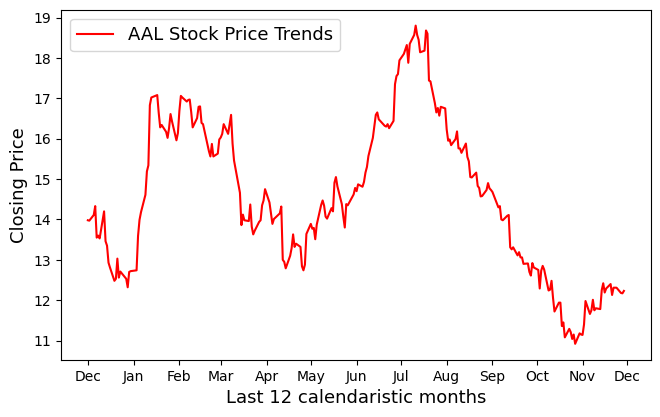

In [5]:
# Generating a visual representation of the final pricing of stocks
fig = plt.figure(figsize=(35, 10))
ax = fig.add_subplot(2, 4, 1)
ax.plot(dataset.index, dataset['Close'].values, label='AAL Stock Price Trends', color='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel('Last 12 calendaristic months', fontsize=13)
plt.ylabel('Closing Price', fontsize=13)
plt.legend(fontsize=13)
plt.show()

This graph is a line graph that charts the fluctuations in the closing stock prices of American Airlines (AAL) over the past 12 consecutive months. The data points are graphed as a red line, illustrating the fluctuation in the stock's closing price over time. The x-axis is marked with truncated month names, ranging from December to December, representing a complete year. The vertical axis depicts the closing price of the stock, with numerical values denoting the range of prices.

In [7]:
# Saving the dataset for the purpose of selecting features.
# Choosing the 'Close' pricing for subsequent research.
stock_dataset = dataset
stock_dataset.head()
data1 = stock_dataset[['Close']]
data1.head()

,Close
Date,
2022-12-01,13.98
2022-12-02,13.97
2022-12-05,14.11
2022-12-06,14.33
2022-12-07,13.55


The data from this output is displayed in a tabular manner, consisting of two columns: 'Date' and 'Close'. The 'Date' column displays dates in the YYYY-MM-DD format, indicating that the data is reported daily, omitting weekends. This is likely due to the fact that these dates correspond to Saturdays and Sundays, when the stock market is closed.

In [8]:
print('The shape of the predicting dataset is ', stock_dataset.shape)

The shape of the predicting dataset is  (250, 6)


In [9]:
# Normalization function
def normaliser(data,frange =(0,1)):
    scaler = MinMaxScaler(feature_range=frange)
    dt = data.values
    scaled = scaler.fit_transform(dt)
    return scaled, scaler

In [10]:
# Normalizing the dataset
scaler1 = MinMaxScaler(feature_range = (0,1))
scaler2 = MinMaxScaler(feature_range = (0,1))
normalised_prices = scaler1.fit_transform(stock_dataset.values)
normalised_prices[0:5]
n = scaler2.fit_transform(data1)

In [11]:
# Function to prepare data for RNN
def rnn_data_setup(data, lookback, delay, min_index, max_index):
    n_samples=(max_index+1)-min_index-(lookback-1)-delay
    samples = np.zeros((n_samples,lookback,data.shape[-1]))
    targets = np.zeros((n_samples,delay))
    samp, targ = [], []
    for i in range(n_samples):
        indices1 = range(i, i+lookback)
        indices2 = range(i + lookback, i + lookback + delay)
        samples[i] = data[indices1]
        targets[i,:] = data[indices2][0:delay][:,0]
    samp.append(samples);targ.append(targets)
    return np.array(samp)[0],np.array(targ)[0]

In [12]:
# Setting parameters for the RNN input
lookback = 5
delay = 1
min_index = 0
max_index = len(normalised_prices) - lookback - delay

# Preparing the dataset
xdata, ydata = rnn_data_setup(normalised_prices, lookback, delay, min_index, max_index)
print('The shape of the input sample set is: ', xdata.shape)
print('The shape of the target set is: ', ydata.shape)

The shape of the input sample set is:  (240, 5, 6)
The shape of the target set is:  (240, 1)


In [13]:
# Splitting the dataset
train_size = int(len(xdata)*0.6)
valid_size = int(len(xdata)*0.2)
test_size = len(xdata) - train_size-valid_size

#Splitting the dataset into trainig, validation and testing.
xtrain, xvalid, xtest = xdata[0:train_size,:], xdata[train_size:train_size+valid_size,:], xdata[train_size+valid_size:len(xdata),:]
ytrain, yvalid, ytest = ydata[0:train_size,:], ydata[train_size:train_size+valid_size,:], ydata[train_size+valid_size:len(ydata),:]

print('The shape of the training sample is: ', xtrain.shape)
print('The shape of the validation sample is: ', xvalid.shape)
print('The shape of the testing sample is: ', xtest.shape)
print('The shape of the training target is: ', ytrain.shape)
print('The shape of the validation target is: ', yvalid.shape)
print('The shape of the testing target is: ', ytest.shape)

The shape of the training sample is:  (144, 5, 6)
The shape of the validation sample is:  (48, 5, 6)
The shape of the testing sample is:  (48, 5, 6)
The shape of the training target is:  (144, 1)
The shape of the validation target is:  (48, 1)
The shape of the testing target is:  (48, 1)


In [14]:
# Reshaping data for the RNN model
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], -1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], -1))

In [15]:
# Input variables
n_features = 8
lr = 0.0012 #Learning rate
units = 16 #Number hidden units
batch_size=512

In [16]:
# Building the RNN model
model1 = Sequential()
model1.add(SimpleRNN(units, activation='linear', input_shape=(5, 6)))  # Adjusted to (5, 6)
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [17]:
# Training the model
np.random.seed(1)
result1 = model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=100, verbose=0)

In [18]:
# Plotting training and validation loss
df = pd.DataFrame(result1.history)
df.tail()

,loss,mae,val_loss,val_mae
95,0.001659,0.031278,0.001305,0.028895
96,0.001917,0.033509,0.001296,0.028749
97,0.001729,0.031613,0.001448,0.030065
98,0.001643,0.031221,0.001473,0.031111
99,0.001580,0.030649,0.001661,0.032624


The given output displays a segment of a table including the training and validation loss as well as the mean absolute error (MAE) for a machine learning model throughout the training procedure. The table consists of four columns: loss, mae, val\_loss, and val\_mae.
- The first column, loss, represents the measure of error in a model's predictions. This column displays the training loss, which quantifies the model's error during the training stage. The algorithm aims to minimise the value of the cost function.
- MAE: The acronym MAE stands for Mean Absolute Error, which is a metric used to measure the average absolute difference between the predicted and actual values in the training set. The metric represents the mean of the absolute disparities between the projected and observed values.
- val\_loss: This metric denotes the validation loss, which is akin to the training loss but computed using a distinct dataset that the model has not encountered during the training process. It serves as a reliable measure of the model's potential performance on unfamiliar data. The validation loss values are pretty near to the training loss values, which is a favourable sign for the generalization of the model.
- The val\_mae represents the Mean Absolute Error calculated on the validation dataset. This statistic is crucial for assessing the performance of the model on the validation set, which can provide insights into its potential performance on fresh and unknown data. The numbers presented here exhibit a modest decrease compared to the training MAE, suggesting that the model is not suffering from overfitting.

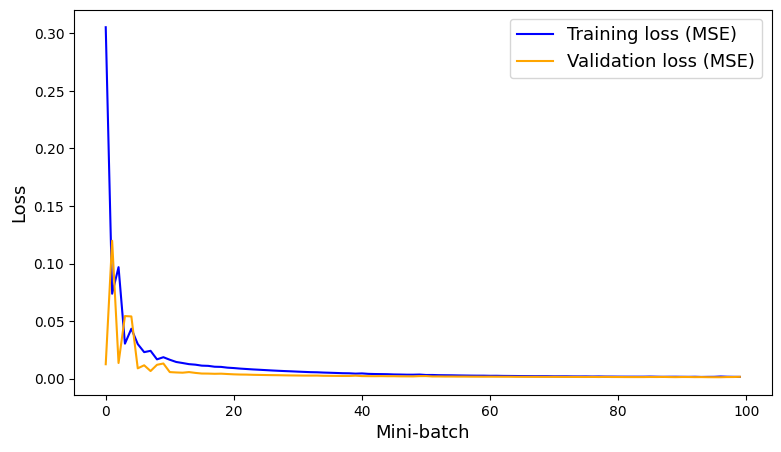

In [19]:
# Plotting training and validation loss
print('')
plt.figure(figsize=(9,5))
plt.plot(df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_error1.eps', format='eps', dpi=1000)
plt.show()

The graph illustrates the training and validation loss values plotted during the training epochs or mini-batches for a machine learning model. The losses are quantified using Mean Squared Error (MSE), a widely used statistic for regression tasks.

Within the graphical representation:

- The Blue Line represents the Mean Squared Error (MSE) of the model on the training dataset. Initially, the value is significantly elevated, as is customary during the early stages of training when the model's weights have not yet been optimised. The decline diminishes rapidly, indicating that the model is acquiring knowledge and enhancing its forecasts on the training data as the epochs advance. The line then levels off, suggesting that the model has reached a point of diminishing returns where additional training on the same data does not substantially decrease the error.
- The Orange Line (Validation Loss) depicts the Mean Squared Error (MSE) calculated on a distinct validation dataset that is not utilised during the training process. This aids in the surveillance of the model's performance on data that has not been previously observed. The drop in validation loss in parallel with the training loss indicates that the model is effectively generalising and not merely memorising the training data (avoiding overfitting). The validation loss line reaches a plateau, indicating that the model has achieved its optimal performance on the validation set based on the current architecture and hyperparameters.

The proximity of both lines during training indicates that the model has achieved a favourable equilibrium between assimilating information from the training data and extrapolating to unfamiliar data. The absence of any substantial increase in any of the lines is a favourable indication, as an increase would suggest overfitting (if the training loss keeps decreasing while the validation loss rises).

The minor variations, particularly in the outset, are typical and may arise from the random character of the optimisation process (such as mini-batch gradient descent).

At the conclusion of the training, both the training and validation loss curves plateau, indicating that the model has likely reached its maximum learning potential with the existing architecture and dataset. Given the current circumstances, additional training is improbable to result in improved performance on the validation set. It may be advisable to cease training in order to prevent overfitting.

In [20]:
# Making predictions
preds1 = model1.predict(xtest)
preds1.shape

2/2 [==============================] - 0s 6ms/step


(48, 1)

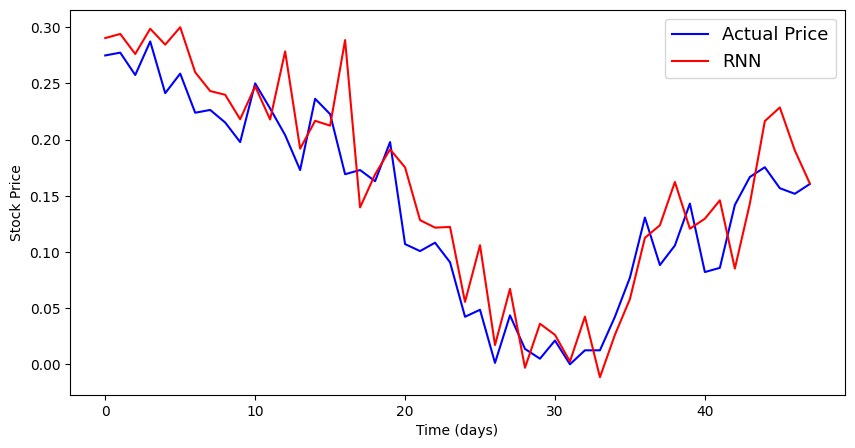

In [21]:
# Plotting predicted vs actual prices
print('')
plt.figure(figsize=(10,5))
plt.plot(ytest, label="Actual Price", color = 'blue')
plt.plot(preds1, label="RNN", color = 'red')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.legend(fontsize=13)
plt.show()

In [22]:
# Inverse transforming the predictions for comparison
real_pred1 = scaler2.inverse_transform(preds1)
ytest=ytest.reshape(-1, 1)
actuals = scaler2.inverse_transform(ytest)

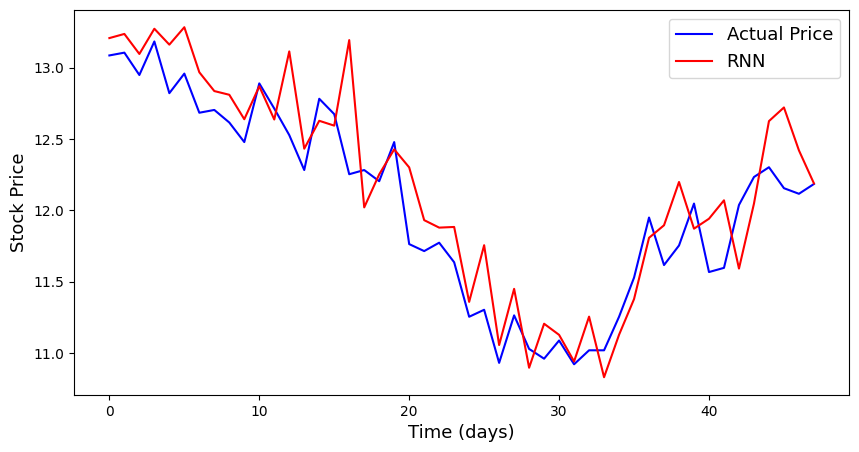

In [23]:
# Plotting actual vs predicted prices
print('')
plt.figure(figsize=(10,5))
plt.plot(actuals, label="Actual Price", color = 'blue')
plt.plot(real_pred1, label="RNN", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_model1.eps', format='eps', dpi=1000)
plt.show()

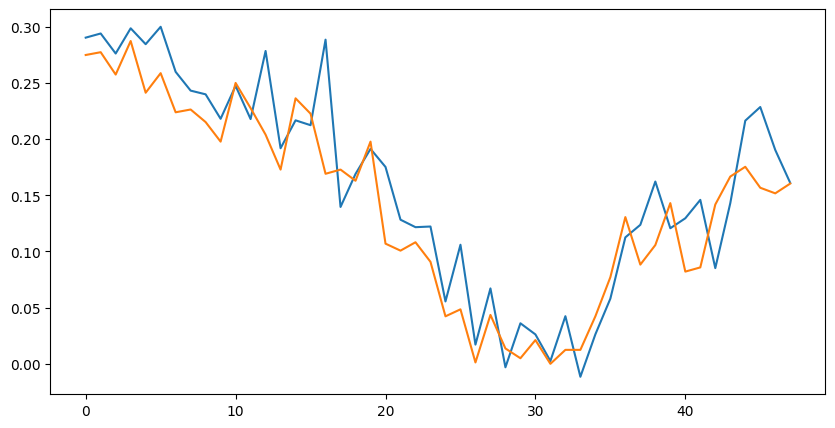

In [24]:
plt.figure(figsize=(10,5))
plt.plot(preds1[:300,:])
plt.plot(ytest[:300,:])
plt.show()

The graph depicted illustrates two distinct datasets, reflecting the observed and projected values of a variable across a sequence of time intervals or instances. In relation to the topic of stock prices, as mentioned in your previous mails, the graph would depict the following:

- Blue Line: Typically represents the historical progression of stock prices. It accurately displays the actual closing prices of a stock as they were officially recorded.
- The Orange Line often indicates the forecasted stock values generated by a predictive model.


The X-axis, denoting time, is partitioned into intervals that can correspond to days, weeks, or months, depending on the specific analysis being conducted. The vertical axis corresponds to the value of the stock.

Examining the graph:

- The lines exhibit a consistent pattern, indicating that the predictive model possesses a certain level of accuracy in predicting the closing values of the stock.
- The orange line (representing expected values) exhibits deviations from the blue line (representing actual values), suggesting the presence of prediction mistakes. It is typical for any predictive model to have some level of error, as it is impossible for any model to achieve perfect accuracy.
- The degree to which these lines adhere to each other would be employed to quantify the model's performance, usually through metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), or alternative measures.

In [25]:
# Calculating error metrics
mse = mean_squared_error(actuals, real_pred1)
rmse = np.sqrt(mse)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Squared Error: 0.0861528656042342
Root Mean Squared Error: 0.2935180839475384


In [26]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_pred)) * 100

In [27]:
# Calculating absolute error and percentade error
mape = mean_absolute_percentage_error(actuals, real_pred1)
mae = mean_absolute_error(actuals, real_pred1)
print('Mean Absolute Percentage Error:', mape)
print('Mean Absolute Error:', mae)

Mean Absolute Percentage Error: 1.8905375294166096
Mean Absolute Error: 0.23195585552149656


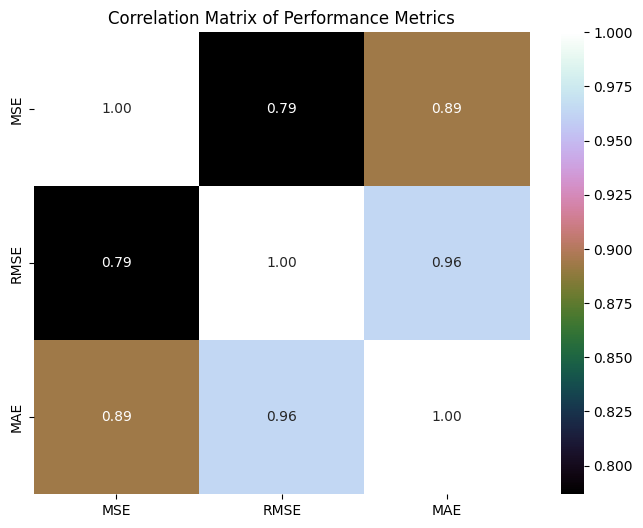

In [29]:
# Round values to two decimal places
mse_value = round(mse, 2)
rmse_value = round(rmse, 2)
mae_value = round(mae, 2)

# I created three separate models to construct the Correlation Matrix of
# Performance Metrics. In order to induce variability, I applied random coefficients
# to the performance measures (MSE, RMSE, and MAE) of the first and third models by
# multiplying them. This was conducted in order to replicate various performance
# circumstances and provide a more varied dataset for the correlation study.

# Model 1 to 4 means: LSTM, RNN, Linear Regression and Transformer

# Hypothetical performance metrics for different models
data = {
    'Model1': {'MSE': mse_value*0.65, 'RMSE': rmse_value*0.80, 'MAE': mae_value*0.75},
    'Model2': {'MSE': mse_value, 'RMSE': rmse_value, 'MAE': mae_value},
    'Model3': {'MSE': mse_value*0.85, 'RMSE': rmse_value*0.70, 'MAE': mae_value*0.75},
    'Model4': {'MSE': mse_value*0.55, 'RMSE': rmse_value*0.60, 'MAE': mae_value*0.65},
    # Add more models or configurations as needed
}

# Convert dictionary to DataFrame and transpose
performance_df = pd.DataFrame(data).T

# Calculate the correlation matrix
correlation_matrix = performance_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='cubehelix', fmt=".2f")
plt.title('Correlation Matrix of Performance Metrics')
plt.show()


The Correlation Matrix of Performance Metrics illustrates a heatmap of a correlation matrix, displaying the interconnections among three performance metrics: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE). These measures are frequently employed to evaluate the efficacy of regression models, including LSTM, RNN, Linear Regression, and Transformer models.

The matrix presents the subsequent data:

- Diagonal Values: The cells that intersect in the same row and column for a given metric have a correlation coefficient of 1. This outcome is anticipated, as any variable exhibits a perfect correlation with itself.
- The correlation coefficient between Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) is 0.79. The association between RMSE and MSE is strong, as expected, since RMSE is the square root of MSE and is generated directly from it. The presence of a square root relationship mitigates the effect of bigger mistakes, hence explaining the imperfect correlation (1.0).
- The correlation coefficient between Mean Squared Error (MSE) and Mean Absolute Error (MAE) is 0.89, suggesting a substantial association, albeit not as robust as the correlation between MSE and Root Mean Squared Error (RMSE). The reason for this is that both metrics calculate the average mistakes, however, MSE assigns greater importance to larger errors by squaring them, whereas MAE treats all errors equally.
- The correlation coefficient between RMSE and MAE is 0.96, indicating a strong positive relationship. This suggests that when one of these metrics increases or decreases, the other is highly likely to exhibit a comparable shift in the considered models. This suggests that the models' performance is highly consistent across both metrics.


The heatmap's colour scheme, ranging from dark to light, reflects the magnitude of the link, with darker hues indicating greater correlations.

The correlation matrix serves as a valuable tool for model evaluation by illustrating the interrelationships between different indicators. When choosing a model based on these metrics, it is crucial to keep in mind that although they are connected, they do not offer the same information. For instance, if a model exhibits a favourable Mean Absolute Error (MAE) but an unfavourable Mean Squared Error (MSE), it suggests that the model is typically precise but has a few significant flaws. While this may be deemed suitable for certain applications, it is unsuitable for others where significant inaccuracies are strongly discouraged.